<a href="https://colab.research.google.com/github/omkarbhalerao40/GANs/blob/master/GAN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Required Libraries

In [0]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose,ToPILImage
from torchvision.datasets import MNIST

### Creating an object of the MNIST dataset
##### MNIST dataset consists of a database of hand written digits

In [0]:
mnist = MNIST(root = 'data',
              train = True,
              download = True,
              transform = Compose([ToTensor(), Normalize(mean = (0.5,), std = (0.5,))]))



Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


##### Let's look at an image from the object created

In [0]:
img, label = mnist[0]  #take first image and corresponding label
print('Label', label)
print('Img size', img.shape) #channel, height, width
print('Image', img[:,10:15,10:15]) #Printing a few pixel values of the image
torch.min(img), torch.max(img) #Printing the minimum and maximum values of the tensor

Label 5
Img size torch.Size([1, 28, 28])
Image tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

##### Create a function to denormalize the tensor from (-1,1) to (0,1) show that it can plotted as pixels

In [0]:
#Denormalize and convert to numpy to view images 
#Since matplotlib cant show tensors

def denorm(x) :
  out = (x + 1) /2
  return out.clamp(0,1)

##### A function to display an image

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy() 
    plt.imshow(npimg[0], cmap = 'gray')
    plt.show()

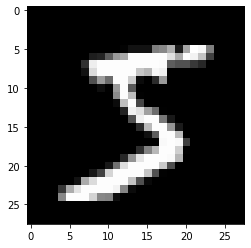

In [0]:
imshow(img)

### Create a data loader which loads images from the dataset object in batches

In [0]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle = True)

##### Data loader returns batches of images with labesl

First Batch
torch.Size([100, 1, 28, 28])
torch.Size([100])


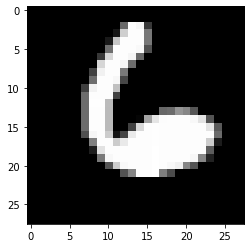

tensor([6, 1, 9, 8, 3, 7, 1, 1, 8, 8, 9, 0, 3, 5, 8, 1, 2, 8, 6, 2, 5, 2, 3, 6,
        7, 0, 9, 2, 3, 7, 8, 7, 5, 7, 2, 2, 9, 7, 2, 0, 5, 4, 3, 6, 4, 7, 5, 4,
        3, 4, 6, 2, 0, 8, 8, 6, 9, 4, 0, 1, 9, 7, 6, 2, 9, 0, 1, 7, 2, 2, 5, 8,
        6, 6, 3, 7, 8, 5, 1, 7, 6, 3, 6, 8, 9, 7, 4, 7, 9, 3, 7, 9, 4, 5, 9, 1,
        3, 2, 2, 8])


In [0]:
for img_batch, label_batch in data_loader :  #data_loader ==> (batch of images, corresponding batch of labels)
  print('First Batch')
  print(img_batch.shape)    
  print(label_batch.shape)
  imshow(img_batch[0])
  print(label_batch)
  break

### Create a device variable which can be used to move models and data to the GPU if available

In [0]:
#Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #String variable 
print(device)

cuda


# Creating the Disccriminator

In [0]:
#For Discriminator

image_size = 28*28     #flattened input image size(since we are making fully connected layers)
hidden_size = 256      #Neurons in hidden layers 

In [0]:
#Dicriminator Network

import torch.nn as nn
import torch.nn.functional as F

class Dis(nn.Module) :
  def __init__(self) :
    super(Dis, self).__init__()
    self.fc1 = nn.Linear(image_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, 1)
  
  def forward(self, x) :
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.sigmoid(self.fc3(x))
    return x


In [0]:
D = Dis() #Making an instance of created discriminator class
D.to(device) #Shifting model to device

Dis(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
print(D)

Dis(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


# Creating the Generator

In [0]:
#For Generator Network

latent_size = 100  #size of random noise vector which acts as input to the generator

In [0]:
#Generator Network

class Gen(nn.Module) :
  def __init__(self) :
    super(Gen, self).__init__ ()
    self.fc1 = nn.Linear(latent_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, image_size)
    
  def forward(self, x) :
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return x

In [0]:
G = Gen() #Making an instance of created discriminator class
G.to(device) #Shifting the model to the device

Gen(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
)

In [0]:
print(G)

Gen(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=784, bias=True)
)


torch.Size([2, 784])
torch.Size([2, 28, 28])


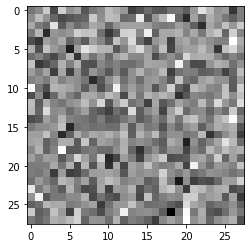

In [0]:
#Generator output for random noise

y = G(torch.randn(2, latent_size).to(device))
print(y.shape)
gen_images = denorm(y.reshape(-1,28, 28).detach())
print(gen_images.shape)

plt.imshow(gen_images[0].cpu(), cmap = 'gray')

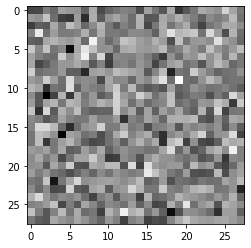

In [0]:
# imshow(gen_images[1].reshape(-1, 28, 28).cpu()) #alternate way of displaying image

##### Creating optimizers for both networks to carry out gradient descent

In [0]:
criterion = nn.BCELoss()  #Using the Binary cross entropy loss
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [0]:
#Function for clearing previously stored gradients

def reset_grad() :
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

##### Function for training the discriminator

In [0]:
def train_discriminator(images) :
  #Create labels which are later used as input for the BCE loss
  real_labels = torch.ones(batch_size, 1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)

  #Loss for real images
  outputs = D(images)
  d_loss_real = criterion(outputs, real_labels) #want probs to be 1 for real iamges
  real_score = outputs #probabilites of disc for real images

  #Loss for fake images
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, fake_labels) #want probs to be 0 for gen iamges
  fake_score = outputs #probabilites of disc for fake images

  #Combine Loss
  d_loss = d_loss_real + d_loss_fake

  #Reset Gradients
  reset_grad()

  #Compute Gradients
  d_loss.backward()

  #Adjust paramters using BackProp
  d_optimizer.step()

  return d_loss, real_score, fake_score

##### Function for training the Generator

In [0]:
def train_generator() :
  #Generate fake images and calculate loss
  z = torch.randn(batch_size, latent_size).to(device)
  fake_images = G(z)
  d_outptus = D(fake_images)
  labels = torch.ones(batch_size).to(device)
  g_loss = criterion(d_outptus, labels)

  #Reset Gradients
  reset_grad()

  #Compute gradients
  g_loss.backward()

  #Adjust parameters using backprop
  g_optimizer.step()

  return g_loss, fake_images

In [0]:
#Place to store model checkpoint
import os

sample_dir = 'sample'
if not os.path.exists(sample_dir) :
  os.makedirs(sample_dir)

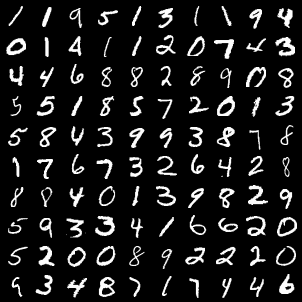

In [0]:
#Saving batch of some real images
from IPython.display import Image
from torchvision.utils import save_image

#save some real images
for images, _ in data_loader :
  images = images.reshape(images.size(0), 1, 28, 28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
  break
Image(os.path.join(sample_dir, 'real_images.png'))

##### Saving a batch of fake images to see the transition of the image as the GAN improves 

Saving fake_images-0000.png


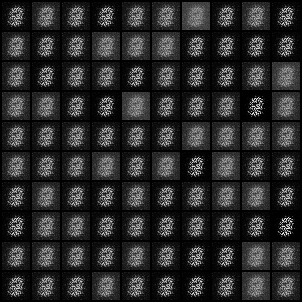

In [0]:
#Saving batch of fake iamges
#Keep same input vector to check evolution of Generator on same input

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index) :
   fake_images = G(sample_vectors)
   fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
   fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
   print('Saving', fake_fname)
   save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)
  
#before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

# Training the GAN

In [0]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch [0/50], Step [200/600], d_loss: 0.1279, g_loss: 4.0235, D(x): 0.97, D(G(z)): 0.09
Epoch [0/50], Step [400/600], d_loss: 0.2160, g_loss: 3.3535, D(x): 0.91, D(G(z)): 0.09
Epoch [0/50], Step [600/600], d_loss: 0.4591, g_loss: 2.4260, D(x): 0.87, D(G(z)): 0.22
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.3732, g_loss: 4.6863, D(x): 0.93, D(G(z)): 0.18
Epoch [1/50], Step [400/600], d_loss: 0.3588, g_loss: 3.3143, D(x): 0.93, D(G(z)): 0.21
Epoch [1/50], Step [600/600], d_loss: 0.5473, g_loss: 3.6321, D(x): 0.81, D(G(z)): 0.14
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.4803, g_loss: 2.7532, D(x): 0.92, D(G(z)): 0.26
Epoch [2/50], Step [400/600], d_loss: 0.4438, g_loss: 3.5628, D(x): 0.93, D(G(z)): 0.20
Epoch [2/50], Step [600/600], d_loss: 1.8402, g_loss: 2.5345, D(x): 0.57, D(G(z)): 0.38
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 1.5511, g_loss: 1.6017, D(x): 0.55, D(G(z)): 0.38
Epoch [3/50], Step [400/600], d_loss

In [0]:
#Save the model

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

##### Creating a video of the GAN output on the noise

In [0]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

# Visualizing Losses

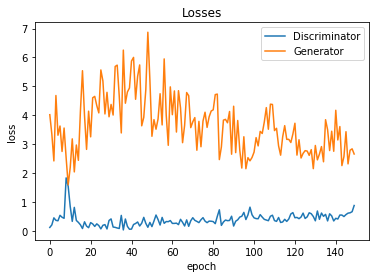

In [0]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

##### Plotting the probabilities of the Discriminator predicting real on true images and false on generator images

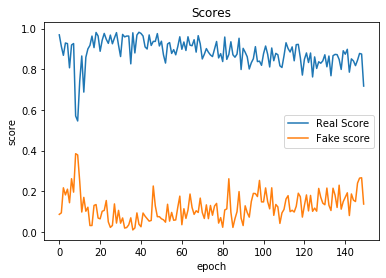

In [0]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');